### Step 1: Environment Setup & Data Ingestion

In [1]:
# Neerayan Kiritharan
# Script to initialize a Spark session and import functions
from pyspark.sql import SparkSession, functions as F

# Create Spark App
# Initialize Spark session
spark = SparkSession.builder.appName("SriLankanVehiclePriceAnalysis").getOrCreate()
print("Spark Session Created Successfully, Spark version:", spark.version )
# Neerayan Kiritharan
# Load the dataset
df = spark.read.format("csv").load("/content/car_price_dataset_unclean.csv",
                                   header=True, inferSchema=True)
df.show(5, truncate=False)
print(f"Total records: {df.count()}")
df.printSchema()

Spark Session Created Successfully, Spark version: 4.0.1
+----------+-----+-----+----+-----------+---------+---------+-----------+----------------------+----------+----------+---------+-------------+--------------+------------+------------+-----+
|Unnamed: 0|Brand|Model|YOM |Engine (cc)|Gear     |Fuel Type|Millage(KM)|Town                  |Date      |Leasing   |Condition|AIR CONDITION|POWER STEERING|POWER MIRROR|POWER WINDOW|Price|
+----------+-----+-----+----+-----------+---------+---------+-----------+----------------------+----------+----------+---------+-------------+--------------+------------+------------+-----+
|0         |AUDI |A1   |2016|990.0      |Automatic|Petrol   |99000      |Gampaha               |2/5/2025  |No Leasing|USED     |Available    |Available     |Available   |Available   |100.0|
|1         |AUDI |A1   |2017|1000.0     |Automatic|Petrol   |88000      |Colombo               |1/14/2025 |No Leasing|USED     |Available    |Available     |Available   |Available   |

### Step 2: Meta-data Table

In [2]:
# import necessary functions
from pyspark.sql.functions import col, count, sum

metadata = []

for col_name, dtype in df.dtypes:
    distinct_count = df.select(col_name).distinct().count()
    null_count = df.filter(col(col_name).isNull()).count()

    metadata.append((col_name, dtype, distinct_count, null_count))

# Meta Data
metadata_df = spark.createDataFrame(metadata, ["Attribute", "Data Type", "Distinct Values", "Missing Values"])

metadata_df.show(truncate=False)

+--------------+---------+---------------+--------------+
|Attribute     |Data Type|Distinct Values|Missing Values|
+--------------+---------+---------------+--------------+
|Unnamed: 0    |int      |9788           |0             |
|Brand         |string   |50             |0             |
|Model         |string   |1555           |0             |
|YOM           |int      |63             |2             |
|Engine (cc)   |double   |331            |423           |
|Gear          |string   |2              |0             |
|Fuel Type     |string   |5              |226           |
|Millage(KM)   |int      |62             |0             |
|Town          |string   |108            |149           |
|Date          |string   |66             |105           |
|Leasing       |string   |3              |155           |
|Condition     |string   |3              |4             |
|AIR CONDITION |string   |3              |8             |
|POWER STEERING|string   |3              |8             |
|POWER MIRROR 

### Step 3: Data pre-processing (Reducing, and Sorted DataFrame)

In [3]:
# Data pre-porocessing
# import necessary functions
from pyspark.sql.functions import when, to_date, round, lit, concat_ws

# drop initial int id
df = df.drop("Unnamed: 0")

# combine Brand and Model into 01 column
df = (df.withColumn("Brand_Model", concat_ws("_", col("Brand"), col("Model"))).drop("Brand", "Model"))
# reorder columns
cols = ["Brand_Model"] + [c for c in df.columns if c not in ["Brand_Model", "Brand", "Model"]]
df = df.select(*cols)

# columns rename
columns_rename_map = {
    "Millage(KM)": "Mileage",
    "Engine (cc)": "Engine_CC",
    "Fuel Type": "Fuel_Type",
    "AIR CONDITION": "AIR_CONDITION",
    "POWER STEERING": "POWER_STEERING",
    "POWER MIRROR": "POWER_MIRROR",
    "POWER WINDOW": "POWER_WINDOW",
}
df = df.select([col(c).alias(columns_rename_map.get(c, c)) for c in df.columns])

# Ensure numeric types for key columns
for n in ['Mileage', 'Engine_CC', 'Price']:
    if n in df.columns:
        df = df.withColumn(n, col(n).cast('double'))

# Neerayan Kiritharan
# Create Mileage category ordinal variable
df = df.withColumn('Mileage_Category',
  when(col('Mileage') <= 30000, 'Low')
    .when(col('Mileage') <= 60000, 'Medium')
    .when(col('Mileage') <= 100000, 'High')
    .otherwise('Very High')
)

# Round Price to 2 decimal places
df = df.withColumn('Price', round(col('Price'), 2))
# Calculate Car_Age: 2026 - YOM
df = df.withColumn('Vehice_Age', lit(2026) - col('YOM'))
# Extract date features
df = df.withColumn('Date', to_date(col('Date'), 'M/d/yyyy'))

df.show(2, truncate=False)

+-----------+----+---------+---------+---------+-------+-------+----------+----------+---------+-------------+--------------+------------+------------+-----+----------------+----------+
|Brand_Model|YOM |Engine_CC|Gear     |Fuel_Type|Mileage|Town   |Date      |Leasing   |Condition|AIR_CONDITION|POWER_STEERING|POWER_MIRROR|POWER_WINDOW|Price|Mileage_Category|Vehice_Age|
+-----------+----+---------+---------+---------+-------+-------+----------+----------+---------+-------------+--------------+------------+------------+-----+----------------+----------+
|AUDI_A1    |2016|990.0    |Automatic|Petrol   |99000.0|Gampaha|2025-02-05|No Leasing|USED     |Available    |Available     |Available   |Available   |100.0|High            |10        |
|AUDI_A1    |2017|1000.0   |Automatic|Petrol   |88000.0|Colombo|2025-01-14|No Leasing|USED     |Available    |Available     |Available   |Available   |97.0 |High            |9         |
+-----------+----+---------+---------+---------+-------+-------+------

#### Data Cleaning

In [4]:
# Checking for duplicate rows
print('Duplicate rows:', df.count() - df.distinct().count())

# Remove duplicate rows
df = df.dropDuplicates()
print('Rows after dropping duplicates:', df.count())

# Check Invalid Numeric Values
num_cols = [c for c, t in df.dtypes if t in ("int", "double", "float")]

for c in num_cols:
    print(c, df.filter(col(c) < 0).count())

# Remove invalid numeric values where applicable
from pyspark.sql.functions import col, when

for c in num_cols:
    df = df.withColumn(c, when(col(c) < 0, None).otherwise(col(c)))
print('Rows after cleaning invalid values:', df.count())

# Checking for missing values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# get mean value of Engine_CC column
mean = df.select(F.round(F.mean(df["Engine_CC"]))).collect()[0][0]
mean

# fill null values in Engine_CC column with mean values
df = df.na.fill(mean, ["Engine_CC"])
print('Rows after adding mean value to engine cc nulls:', df.count())

# Removing rows with critical missing values
df = df.dropna()
print('Rows after dropping critical nulls:', df.count())

# Final checking for null values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Sorted DataFrame (cleaned data, sorted by Date ascending)
cleaned_df = df.orderBy(F.col("Date").asc())

# New Dataframe
cleaned_df.show(2, truncate=False)
df.printSchema()

Duplicate rows: 441
Rows after dropping duplicates: 9836
YOM 0
Engine_CC 458
Mileage 0
Price 0
Vehice_Age 0
Rows after cleaning invalid values: 9836
+-----------+---+---------+----+---------+-------+----+----+-------+---------+-------------+--------------+------------+------------+-----+----------------+----------+
|Brand_Model|YOM|Engine_CC|Gear|Fuel_Type|Mileage|Town|Date|Leasing|Condition|AIR_CONDITION|POWER_STEERING|POWER_MIRROR|POWER_WINDOW|Price|Mileage_Category|Vehice_Age|
+-----------+---+---------+----+---------+-------+----+----+-------+---------+-------------+--------------+------------+------------+-----+----------------+----------+
|          0|  2|      859|   0|      225|      0| 148| 105|    155|        4|            8|             8|          14|           7|    0|               0|         2|
+-----------+---+---------+----+---------+-------+----+----+-------+---------+-------------+--------------+------------+------------+-----+----------------+----------+

Rows after

### Step 4: Transform Categorical to Numerical

In [5]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# initial feature engineering
from datetime import date
categorical_columns = ['Brand_Model', 'Gear', 'Fuel_Type', 'Town', 'Leasing', 'Condition', 'AIR_CONDITION', 'POWER_STEERING', 'POWER_MIRROR', 'POWER_WINDOW', 'Mileage_Category']

numerical_columns = ['YOM', 'Engine_CC', 'Mileage', 'Vehice_Age']

# index the string columns
indexers = [StringIndexer(inputCol=col, outputCol="{0}_index".format(col), handleInvalid="keep", stringOrderType="alphabetAsc") for col in categorical_columns]

# encode the indexed values
encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
# Neerayan Kirithtan
# create input columns
input_columns = [encoder.getOutputCol() for encoder in encoders] + numerical_columns

# vectorize the encoded values
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")

# create the pipeline to transform the data
pipeline = Pipeline(stages=indexers + encoders + [assembler])

data_model = pipeline.fit(cleaned_df)
transformed_df = data_model.transform(cleaned_df)

transformed_df.show(5, truncate=False)
transformed_df.printSchema()

+-----------------+----+---------+---------+---------+--------+------------+----------+-------------+---------+-------------+--------------+------------+------------+-----+----------------+----------+-----------------+----------+---------------+----------+-------------+---------------+-------------------+--------------------+------------------+------------------+----------------------+-------------------------+------------------+-----------------------+------------------+---------------------+-----------------------+---------------------------+----------------------------+--------------------------+--------------------------+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Brand_Model      |YOM |Engine_CC|Gear     |Fuel_Type|Mileage |Town        |Date      |Leasing      |Condition|AIR_CONDITION|POWER_STEERING|POWER_MIRROR|POWER_WINDOW|Price|Milea

### Step 5: Summary Statistics

In [6]:
from pyspark.sql.functions import (sum as _sum, mean, stddev, skewness, kurtosis, lit, round)

# get all numerical and indexed categorical columns
stats_columns = [col_name for col_name, dtype in transformed_df.dtypes if dtype in ('int', 'double')]

stats_df = transformed_df.select(stats_columns)

stats = []
for col_name in stats_columns:
    row = stats_df.select(
        lit(col_name).alias("Variable"),
        round(_sum(col_name), 2).alias("Sum"),
        round(mean(col_name), 2).alias("Mean"),
        round(stddev(col_name), 2).alias("StdDev"),
        round(skewness(col_name), 2).alias("Skewness"),
        round(kurtosis(col_name), 2).alias("Kurtosis")
    )
    # Neerayan Kiritharan
    stats.append(row)

final_stats = stats[0]
for s in stats[1:]:
    final_stats = final_stats.union(s)

final_stats.show(truncate=False)

+----------------------+------------+--------+---------+--------+--------+
|Variable              |Sum         |Mean    |StdDev   |Skewness|Kurtosis|
+----------------------+------------+--------+---------+--------+--------+
|YOM                   |1.8420329E7 |2006.79 |9.8      |-1.04   |0.87    |
|Engine_CC             |1.15762118E7|1261.16 |384.85   |0.52    |2.14    |
|Mileage               |1.838606E9  |200305.7|107804.74|1.04    |0.87    |
|Price                 |491594.42   |53.56   |43.69    |3.5     |25.64   |
|Vehice_Age            |176325.0    |19.21   |9.8      |1.04    |0.87    |
|Brand_Model_index     |7834826.0   |853.56  |389.15   |-0.33   |-0.72   |
|Gear_index            |3238.0      |0.35    |0.48     |0.62    |-1.62   |
|Fuel_Type_index       |24512.0     |2.67    |0.78     |-2.59   |5.77    |
|Town_index            |428236.0    |46.65   |27.51    |0.21    |-1.02   |
|Leasing_index         |379.0       |0.04    |0.2      |4.61    |19.26   |
|Condition_index       |9

### Step 6: Correlation Analysis

In [7]:
from pyspark.sql.functions import col, abs as _abs
import builtins

target_variable = "Price"

correlation_results = []

# Calculate correlations
for col_name in stats_columns:
    if col_name != target_variable:
        corr_value = transformed_df.stat.corr(target_variable, col_name)

        # Determine strength
        abs_corr = abs(corr_value)

        if abs_corr >= 0.8:
            strength = "Very Strong"
        elif abs_corr >= 0.6:
            strength = "Strong"
        elif abs_corr >= 0.4:
            strength = "Moderate"
        elif abs_corr >= 0.2:
            strength = "Weak"
        else:
            strength = "Very Weak"

        correlation_results.append(
            (col_name, builtins.round(corr_value, 2), strength)
        )
# Neerayan Kiritharan
correlation_df = spark.createDataFrame(
    correlation_results,
    ["Variable", "Correlation", "Strength"]
).orderBy(col("Correlation").desc())

correlation_df.show(truncate=False)

+----------------------+-----------+---------+
|Variable              |Correlation|Strength |
+----------------------+-----------+---------+
|YOM                   |0.51       |Moderate |
|Engine_CC             |0.18       |Very Weak|
|Brand_Model_index     |0.03       |Very Weak|
|Condition_index       |-0.01      |Very Weak|
|Leasing_index         |-0.03      |Very Weak|
|Fuel_Type_index       |-0.05      |Very Weak|
|Town_index            |-0.06      |Very Weak|
|AIR_CONDITION_index   |-0.11      |Very Weak|
|POWER_STEERING_index  |-0.24      |Weak     |
|POWER_WINDOW_index    |-0.34      |Weak     |
|Mileage_Category_index|-0.34      |Weak     |
|POWER_MIRROR_index    |-0.38      |Weak     |
|Gear_index            |-0.5       |Moderate |
|Mileage               |-0.51      |Moderate |
|Vehice_Age            |-0.51      |Moderate |
+----------------------+-----------+---------+



### Step 7: Visualization (Histogram & Scatter Plot)

In [8]:
# import graph
import matplotlib.pyplot as plt

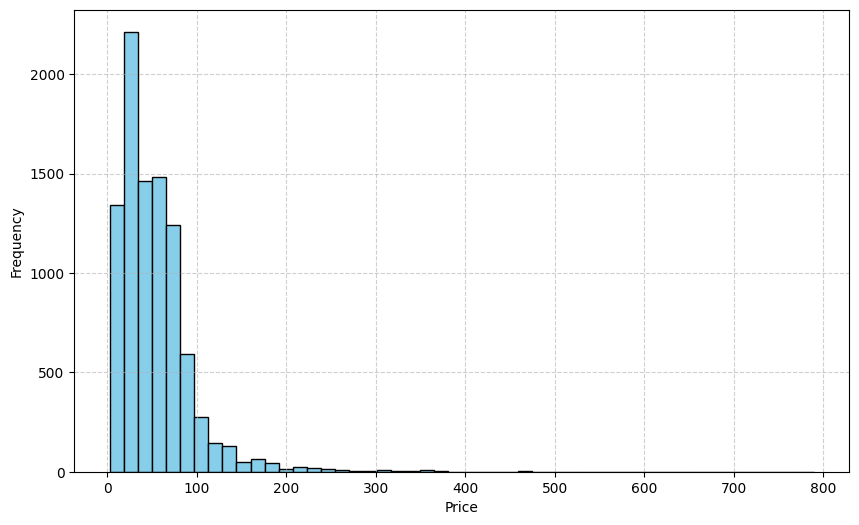

In [9]:
# histogram plot graph

# Convert Spark DataFrame column to Pandas Series for plotting
price_data = transformed_df.select("Price").toPandas()["Price"]
plt.figure(figsize=(10, 6))
plt.hist(price_data, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

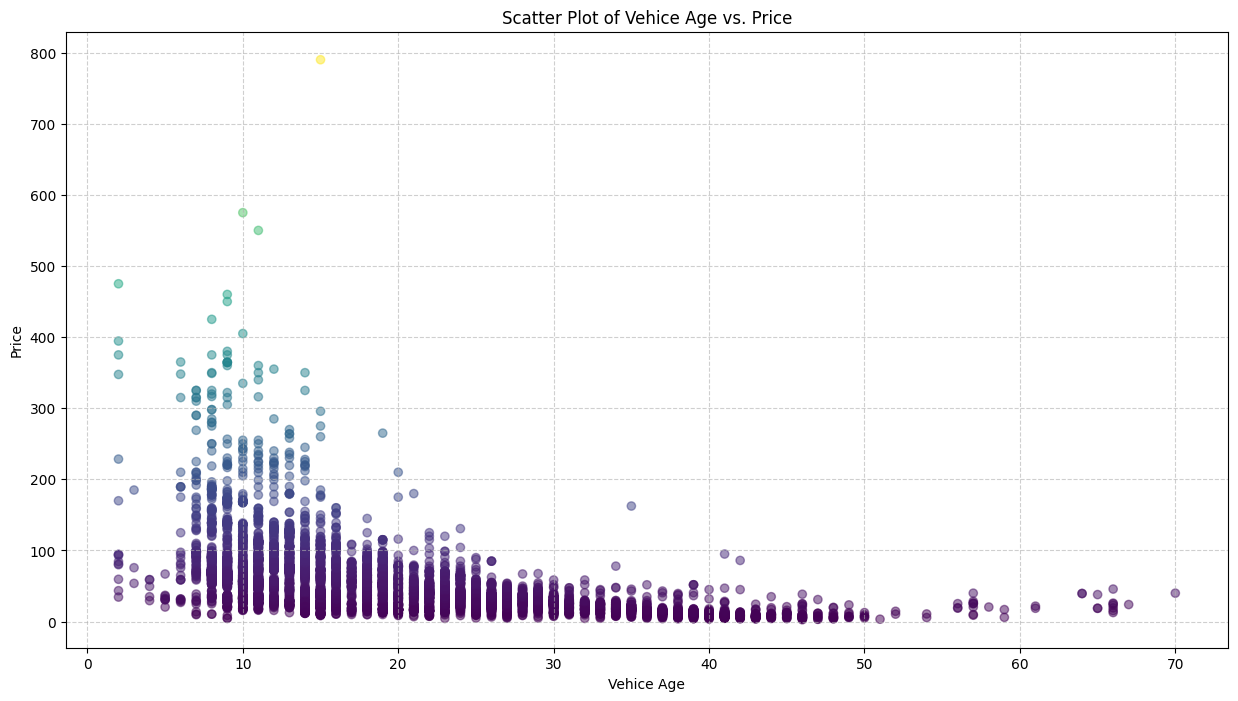

In [10]:
# scatter plot graph
plot_data = transformed_df.select("Vehice_Age", "Price").toPandas()

plt.figure(figsize=(15, 8))
plt.scatter(plot_data["Vehice_Age"], plot_data["Price"], c=plot_data["Price"], cmap="viridis", alpha=0.5)
plt.title('Scatter Plot of Vehice Age vs. Price')
plt.xlabel('Vehice Age')
plt.ylabel('Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Step 8: Time Series Visualization

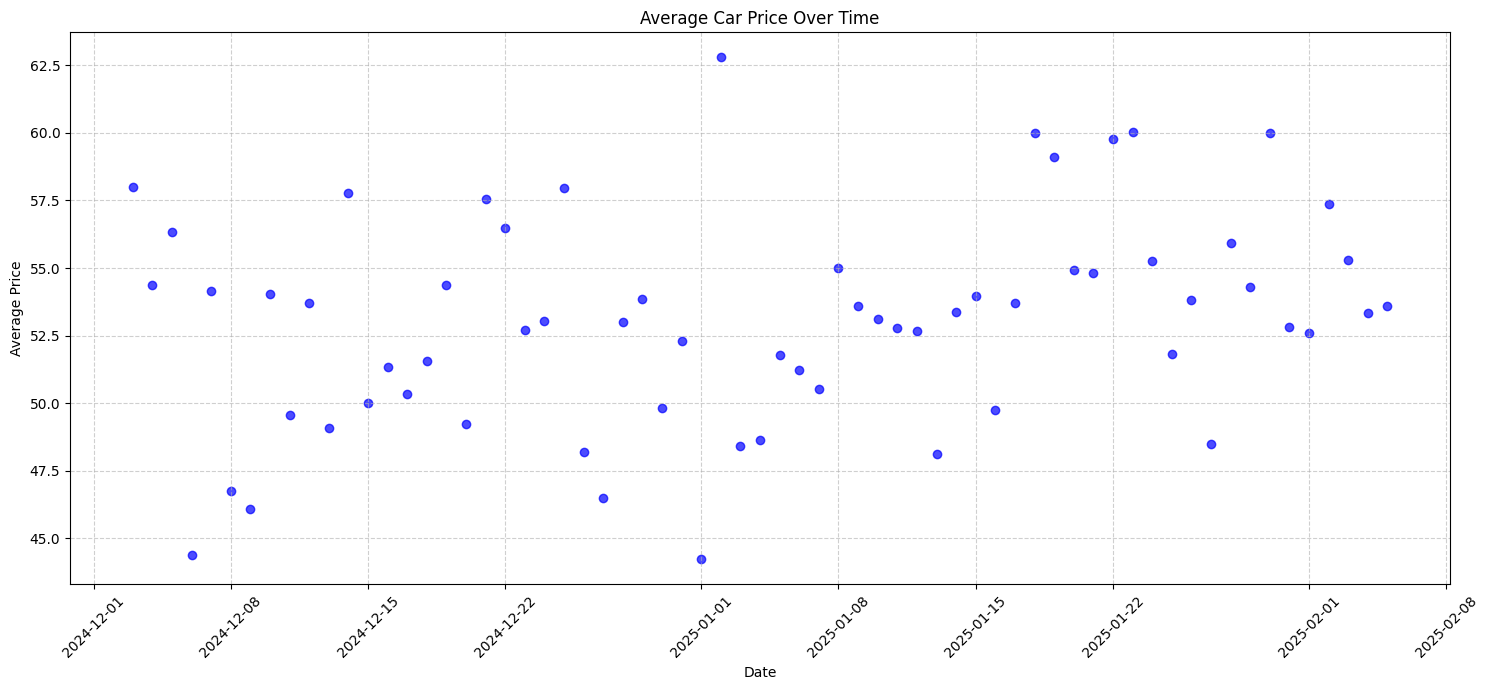

In [11]:
# import avg function
from pyspark.sql.functions import avg

# Calculate average price per date
average_price_by_date = transformed_df.groupBy("Date").agg(avg("Price").alias("Average_Price")).orderBy("Date")

# Convert to Pandas DataFrame for plotting
plot_data_time_series = average_price_by_date.toPandas()

plt.figure(figsize=(15, 7))
plt.scatter(plot_data_time_series["Date"], plot_data_time_series["Average_Price"], alpha=0.7, color='blue')
plt.title('Average Car Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 9: Cleaned Data File Export

In [12]:
# !pip install xlsxwriter
# data export to visualization
from pyspark.sql.functions import split
import pandas as pd

df_visual = (
    transformed_df
    .withColumn("Brand", split(col("Brand_Model"), "_").getItem(0))
    .withColumn("Model", split(col("Brand_Model"), "_").getItem(1))
    .drop("Brand_Model")
)

# drop index / encoded / vector columns
columns_to_drop = [c for c in df_visual.columns if c.endswith("_index") or c.endswith("_encoded") or c == "features" ]
df_visual = df_visual.drop(*columns_to_drop)

pdf = df_visual.toPandas()

# sort by Date and create Vehicle_ID
pdf["Date"] = pd.to_datetime(pdf["Date"]).dt.date
pdf = pdf.sort_values("Date").reset_index(drop=True)

pdf.insert(0, "Vehicle_ID", pdf.index + 1)
ordered_cols = (["Vehicle_ID", "Brand", "Model"] + [c for c in pdf.columns if c not in ["Vehicle_ID", "Brand", "Model"]])

# create sheets
car_facts = pdf[["Vehicle_ID", "Brand", "Model", "YOM", "Vehice_Age", "Engine_CC", "Mileage", "Price", "Date"]]
car_context = pdf[["Vehicle_ID", "Brand", "Model", "Town", "Leasing", "Condition"]]
car_specs = pdf[["Vehicle_ID", "Brand", "Model", "Fuel_Type", "Gear", "Engine_CC"]]
car_features = pdf[["Vehicle_ID", "Brand", "Model", "AIR_CONDITION", "POWER_STEERING", "POWER_MIRROR", "POWER_WINDOW"]]
mileage_info = pdf[["Vehicle_ID", "Brand", "Model", "Mileage", "Mileage_Category"]]

# export excel file
output_path = "/content/car_price_cleaned_visualization.xlsx"

with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    car_facts.to_excel(writer, sheet_name="Car_Facts", index=False)
    car_context.to_excel(writer, sheet_name="Car_Context", index=False)
    car_specs.to_excel(writer, sheet_name="Car_Specs", index=False)
    car_features.to_excel(writer, sheet_name="Car_Features", index=False)
    mileage_info.to_excel(writer, sheet_name="Mileage_Info", index=False)

print(f"Car price cleaned visualization file created: {output_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00
Car price cleaned visualization file created: /content/car_price_cleaned_visualization.xlsx


### Step 10: Predictive Modeling

In [13]:
# feature engineering
# data splitting
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

ml_df = transformed_df.orderBy(col("Date").asc())
window_spec = Window.orderBy(col("Date").asc())
df_with_row_number = ml_df.withColumn("row_num", row_number().over(window_spec))

total_rows = df_with_row_number.count()
train_rows = int(total_rows * 0.8)

# create the train_data
train_data = df_with_row_number.filter(col("row_num") <= train_rows).select(col("features"), col("Price").alias("label"))
# create the test_data
test_data = df_with_row_number.filter(col("row_num") > train_rows).select(col("features"), col("Price").alias("label"))

print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

Training Data Count: 7343
Testing Data Count: 1836


In [14]:
# model training & testing
# LinearRegression model
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Neerayan Kiritharan
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

In [15]:
# prediction model test with test data
lr_predictions = lr_model.transform(test_data)
lr_predictions.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|features                                                                                                                                                     |label|prediction        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|(1653,[825,1511,1516,1590,1626,1630,1633,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,1000.0,154000.0,15.0]) |40.83|41.85080913185516 |
|(1653,[1370,1510,1516,1577,1626,1630,1632,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2002.0,1780.0,253000.0,24.0])|62.75|61.761515997133074|
|(1653,[1416,1511,1516,1598,1626,1630,1632,1635,1638,1641,1647,1649,1650,16

In [16]:
# model evaluation
lr_predictions = lr_model.transform(test_data)
rmse_evaluator_lr = RegressionEvaluator(labelCol="label", predictionCol="prediction",metricName="rmse")
rmse = rmse_evaluator_lr.evaluate(lr_predictions)
print("RMSE:", rmse)

mae_evaluator_lr = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = mae_evaluator_lr.evaluate(lr_predictions)
print("MAE:", mae)

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(lr_predictions)
print("R2:", r2)

RMSE: 26.10075888553257
MAE: 9.354372240017543
R2: 0.6354718398766106


In [17]:
# model training & testing
# Gradient Boosted Tree Regressor

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Neerayan Kiritharan
gbt = GBTRegressor(featuresCol='features', labelCol='label')
gbt_model = gbt.fit(train_data)

In [18]:
# prediction model test with test data
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|features                                                                                                                                                     |label|prediction        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|(1653,[825,1511,1516,1590,1626,1630,1633,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,1000.0,154000.0,15.0]) |40.83|26.27518068411409 |
|(1653,[1370,1510,1516,1577,1626,1630,1632,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2002.0,1780.0,253000.0,24.0])|62.75|51.7114860162132  |
|(1653,[1416,1511,1516,1598,1626,1630,1632,1635,1638,1641,1647,1649,1650,16

In [19]:
# model evaluation
gbt_predictions = gbt_model.transform(test_data)
rmse_evaluator_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction",metricName="rmse")
rmse = rmse_evaluator_gbt.evaluate(gbt_predictions)
print("RMSE:", rmse)

mae_evaluator_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = mae_evaluator_gbt.evaluate(gbt_predictions)
print("MAE:", mae)

r2_evaluator_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator_gbt.evaluate(gbt_predictions)
print("R2:", r2)

RMSE: 20.24314290612731
MAE: 11.298019595334964
R2: 0.7807292529954855


In [20]:
# model training & testing
# Random Forest Regressor

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Neerayan Kiritharan
rf = RandomForestRegressor(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_data)

In [21]:
# prediction model test with test data
rf_predictions = rf_model.transform(test_data)
rf_predictions.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|features                                                                                                                                                     |label|prediction        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------------+
|(1653,[825,1511,1516,1590,1626,1630,1633,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2011.0,1000.0,154000.0,15.0]) |40.83|31.439600309019966|
|(1653,[1370,1510,1516,1577,1626,1630,1632,1635,1638,1641,1647,1649,1650,1651,1652],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2002.0,1780.0,253000.0,24.0])|62.75|44.5196122122215  |
|(1653,[1416,1511,1516,1598,1626,1630,1632,1635,1638,1641,1647,1649,1650,16

In [22]:
# model evaluation
rf_predictions = rf_model.transform(test_data)
rmse_evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction",metricName="rmse")
rmse = rmse_evaluator_rf.evaluate(rf_predictions)
print("RMSE:", rmse)

mae_evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = mae_evaluator_rf.evaluate(rf_predictions)
print("MAE:", mae)

r2_evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator_rf.evaluate(rf_predictions)
print("R2:", r2)

RMSE: 26.366288740306672
MAE: 13.904480368843052
R2: 0.6280172320876755


In [23]:
print("LinearRegression Model")
print("   RMSE:", rmse_evaluator_lr.evaluate(lr_predictions))
print("   MAE:", mae_evaluator_lr.evaluate(lr_predictions))
print("   R2:", r2_evaluator.evaluate(lr_predictions))
print()

print("Gradient Boosted Tree Regressor")
print("   RMSE:", rmse_evaluator_gbt.evaluate(gbt_predictions))
print("   MAE:", mae_evaluator_gbt.evaluate(gbt_predictions))
print("   R2:", r2_evaluator_gbt.evaluate(gbt_predictions))
print()

print("Random Forest Regressor")
print("   RMSE:", rmse_evaluator_rf.evaluate(rf_predictions))
print("   MAE:", mae_evaluator_rf.evaluate(rf_predictions))
print("   R2:", r2_evaluator_rf.evaluate(rf_predictions))

LinearRegression Model
   RMSE: 26.10075888553257
   MAE: 9.354372240017543
   R2: 0.6354718398766106

Gradient Boosted Tree Regressor
   RMSE: 20.24314290612731
   MAE: 11.298019595334964
   R2: 0.7807292529954855

Random Forest Regressor
   RMSE: 26.366288740306672
   MAE: 13.904480368843052
   R2: 0.6280172320876755


#### Future Avg Price Forecasting

In [24]:
from pyspark.sql.functions import max, col, date_add, lit

# get last available date
final_date = ml_df.select(max("Date")).collect()[0][0]
print("Final Date in Dataset:", final_date)

# create dataframe with next 7 days
future_dates = spark.range(1, 8).select(date_add(lit(final_date), col("id").cast("int")).alias("Date"))

future_dates.show()

# select recent records as representative future samples
base_future_df = transformed_df.orderBy(col("Date").desc()).limit(100).drop("Price")

Final Date in Dataset: 2025-02-05
+----------+
|      Date|
+----------+
|2025-02-06|
|2025-02-07|
|2025-02-08|
|2025-02-09|
|2025-02-10|
|2025-02-11|
|2025-02-12|
+----------+



In [25]:
from pyspark.sql.functions import avg, round, col, lit, to_date

all_future_predictions = None

for row in future_dates.collect():
    future_day = row["Date"]   # Python date

    # assign the future date directly
    future_day_df = base_future_df.withColumn("Date", to_date(lit(future_day)))

    predictions = gbt_model.transform(future_day_df).select(col("Date"), col("prediction").alias("Predicted_Price"))

    # average predicted price for the day
    avg_daily_price = predictions.groupBy("Date").agg(round(avg("Predicted_Price"), 2).alias("Avg_Predicted_Price"))

    all_future_predictions = (avg_daily_price if all_future_predictions is None else all_future_predictions.union(avg_daily_price))

all_future_predictions.show(truncate=False)

+----------+-------------------+
|Date      |Avg_Predicted_Price|
+----------+-------------------+
|2025-02-06|53.58              |
|2025-02-07|53.58              |
|2025-02-08|53.58              |
|2025-02-09|53.58              |
|2025-02-10|53.58              |
|2025-02-11|53.58              |
|2025-02-12|53.58              |
+----------+-------------------+



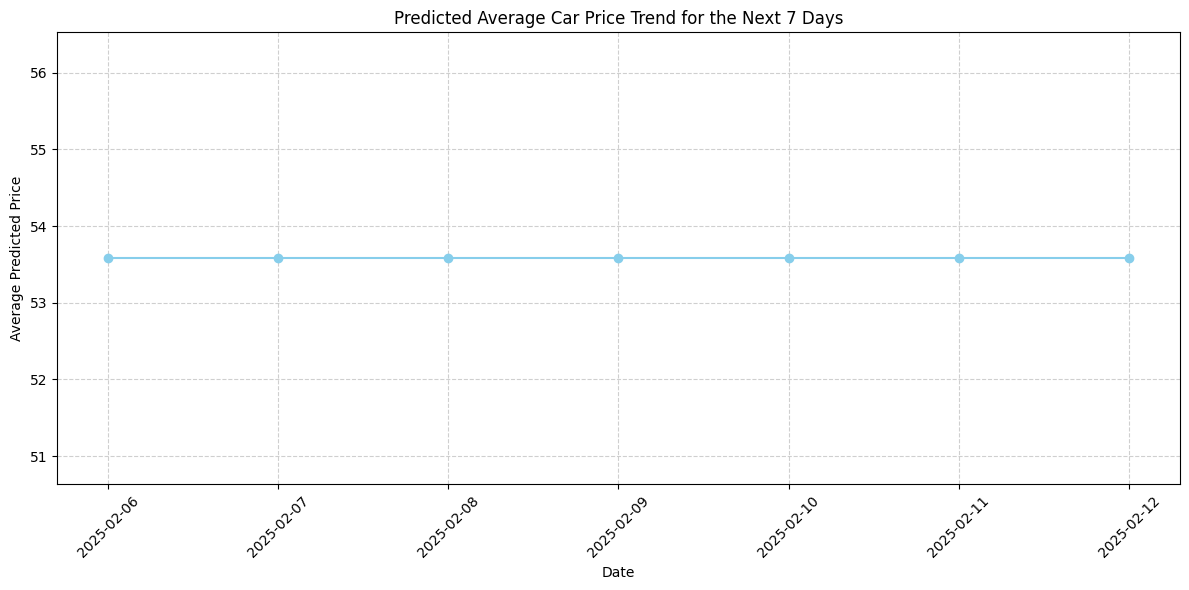

In [26]:
# Convert to Pandas DataFrame for plotting
plot_data_future_predictions = all_future_predictions.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(plot_data_future_predictions["Date"], plot_data_future_predictions["Avg_Predicted_Price"], marker='o', linestyle='-', color='skyblue')
plt.title('Predicted Average Car Price Trend for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Average Predicted Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()